In [3]:
import os
import sys
import numpy as np
import pandas as pd
import torch
import random
import matplotlib.pyplot as plt
from pommerman.agents import SimpleAgent, RandomAgent, PlayerAgent, BaseAgent
from pommerman.configs import ffa_v0_fast_env
from pommerman.envs.v0 import Pomme
from pommerman.characters import Bomber
from pommerman import utility, characters
from pommerman.constants import Action
from collections import deque
from torch.nn.parameter import Parameter
import torch.nn.init as init
import torch.nn.functional as F
import torch.optim as optim
import torch.nn as nn

In [4]:
use_cuda = torch.cuda.is_available()

def get_variable(x):
    """ Converts tensors to cuda, if available. """
    if use_cuda:
        return x.cuda()
    return x

def get_numpy(x):
    """ Get numpy array for both cuda and not. """
    if use_cuda:
        return x.cpu().data.numpy()
    return x.data.numpy()

# Flattens a state s on the form list<dict> where each dict contains information of a state
def flatten_state(s):
    # Usage Example:
	# def forward(self, x):
	#     x = flatten_state(x)
	# where x is np.atleast1d(S[0])
	return torch.from_numpy(np.array([flatten_state_aux(x) for x in s])).float()
	

def flatten_state_aux(s):
    # Lists
    #print ("---------------------------")
    #print (s)
    #print ("---------------------------")
    alive = [1 if x in s['alive'] else 0 for x in range(10,14)]
    board = s['board']
    bomb_blast_strength = s['bomb_blast_strength']
    bomb_life = s['bomb_life']
    # Tuples
    position = s['position']
    # Ints
    blast_strength = s['blast_strength']
    can_kick = s['can_kick']
    ammo = s['ammo']
    # Enums
    teammate = s['teammate'] #9 for FFA
    enemies = s['enemies'] #11,12,13 for FFA and training agent id = 0
    
    a = np.append(np.array(alive),np.array(board).flatten())
    a = np.append(a,np.array(bomb_blast_strength).flatten())
    a = np.append(a,np.array(bomb_life).flatten())
    a = np.append(a,position[0])
    a = np.append(a,position[1])
    a = np.append(a,blast_strength)
    a = np.append(a,can_kick)
    a = np.append(a,ammo)
    # Commented out as we get size 376 but expected 372. I assume we calculated wrong.
    # Makes sense to ignore these imo
    #a = np.append(a,teammate.value)
    #a = np.append(a,[e.value for e in enemies])
    return a.astype(float)

In [5]:
torch.cuda.is_available()

False

Actions: 
    Stop = 0,
    Up = 1,
    Down = 2,
    Left = 3,
    Right = 4,
    Bomb = 5

In [6]:
class ReplayMemory(object):
    """Experience Replay Memory"""
    
    def __init__(self, capacity):
        #self.size = size
        self.memory = deque(maxlen=capacity)
    
    def add(self, *args):
        """Add experience to memory."""
        self.memory.append([*args])
    
    def sample(self, batch_size):
        """Sample batch of experiences from memory with replacement."""
        return random.sample(self.memory, batch_size)
    
    def count(self):
        return len(self.memory)

In [7]:
class DQN(nn.Module):
    """Deep Q-network with target network"""
    
    def __init__(self, n_inputs, n_outputs, learning_rate):
        super(DQN, self).__init__()
        # network
        self.hidden = nn.Linear(n_inputs, n_hidden)
        self.out = nn.Linear(n_hidden, n_outputs)
        # training
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)
    
    def forward(self, x):        
        x = flatten_state(x)
        x = self.hidden(x)
        x = F.relu(x)
        x = self.out(x)
        return F.softmax(x, dim=1)
    
    def loss(self, q_outputs, q_targets):
        return torch.sum(torch.pow(q_targets - q_outputs, 2))
    
    def update_params(self, new_params, tau):
        params = self.state_dict()
        for k in params.keys():
            params[k] = (1-tau) * params[k] + tau * new_params[k]
        self.load_state_dict(params)

In [8]:
# one-hot encoder for the states
def one_hot(i, l):
    a = np.zeros((len(i), l))
    a[range(len(i)), i] = 1
    return a

In [9]:
# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])

In [10]:
#n_inputs = env.observation_space.shape[0]
n_inputs = 372
#n_hidden = 20
n_hidden = 500
n_outputs = env.action_space.n

print('state shape:', n_inputs)
print('action shape:', n_outputs)



state shape: 372
action shape: 6


In [11]:
class TrainingAgent(BaseAgent):
    
    def __init__(self, character=characters.Bomber):
        super().__init__(character)
        
        
    def act(self, obs, action_space):
        return 0

In [12]:
# training settings
debug = False
num_episodes = 10

discount_factor = 1.0 # reward discount factor (gamma), 1.0 = no discount
learning_rate = 0.001 # you know this by now
val_freq = 5 # validation frequency

# setup policy network

#policy = PolicyNet(n_inputs, n_hidden, n_outputs, learning_rate)
#qNet = DQN()
if use_cuda:
    policy.cuda()


In [13]:
# train Deep Q-network

num_episodes = 100
episode_limit = 100
batch_size = 64
learning_rate = 0.005
gamma = 0.99 # discount rate
tau = 0.01 # target network update rate
replay_memory_capacity = 10000
prefill_memory = True
val_freq = 100 # validation frequency

# initialize DQN and replay memory
policy_dqn = DQN(n_inputs, n_outputs, learning_rate)
target_dqn = DQN(n_inputs, n_outputs, learning_rate)
target_dqn.load_state_dict(policy_dqn.state_dict())

replay_memory = ReplayMemory(replay_memory_capacity)

# prefill replay memory with random actions
if prefill_memory:
    print('prefill replay memory')
    # Add four random agents
    agents = []
    #for agent_id in range(4):
    #    agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))
    agents = {
        '0' : SimpleAgent(config["agent"](0, config["game_type"])),
        '1' : RandomAgent(config["agent"](1, config["game_type"])),
        '2' : RandomAgent(config["agent"](2, config["game_type"])),
        '3' : TrainingAgent(config["agent"](3, config["game_type"]))
    }
    env.set_agents(list(agents.values()))
    #env.set_training_agent(3)
    env.set_init_game_state(None)    
    
    
    s = env.reset()
    while replay_memory.count() < replay_memory_capacity:
        a = env.act(s)
        s1, r, d, _ = env.step(a)
        replay_memory.add(s[3], a[3], r[3], s1[3], d)
        s = s1 if not d else env.reset()
        
# training loop
try:
    print('start training')
    epsilon = 1.0
    rewards, lengths, losses, epsilons = [], [], [], []
    for i in range(num_episodes):
        
        # Add four random agents
        agents = []
        #for agent_id in range(4):
        #    agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))
        agents = {
            '0' : SimpleAgent(config["agent"](0, config["game_type"])),
            '1' : RandomAgent(config["agent"](1, config["game_type"])),
            '2' : RandomAgent(config["agent"](2, config["game_type"])),
            '3' : TrainingAgent(config["agent"](3, config["game_type"]))
        }
        env.set_agents(list(agents.values()))
        env.set_training_agent(3)
        env.set_init_game_state(None)
        s = env.reset()
        
        # init new episode
        ep_reward, ep_loss = 0, 0
        for j in range(episode_limit):
            # select action with epsilon-greedy strategy
            if np.random.rand() < epsilon:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    a = policy_dqn(np.atleast_1d(s[3])).argmax().item()
            # perform action
            actions = env.act(s)
            actions.append(a)
            s1, r, d, _ = env.step(actions)
            # store experience in replay memory
            replay_memory.add(s[3], a, r[3], s1[3], d)
            # batch update
            if replay_memory.count() >= batch_size:
                # sample batch from replay memory
                batch = np.array(replay_memory.sample(batch_size))
                ss, aa, rr, ss1, dd = batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
                # do forward pass of batch
                policy_dqn.optimizer.zero_grad()
                Q = policy_dqn(ss)
                # use target network to compute target Q-values
                with torch.no_grad():
                    # TODO: use target net
                    Q1 = target_dqn(ss1)
                # compute target for each sampled experience
                q_targets = Q.clone()
                for k in range(batch_size):
                    q_targets[k, aa[k]] = rr[k] + gamma * Q1[k].max().item() * (not dd[k])
                # update network weights
                loss = policy_dqn.loss(Q, q_targets)
                loss.backward()
                policy_dqn.optimizer.step()
                # update target network parameters from policy network parameters
                target_dqn.update_params(policy_dqn.state_dict(), tau)
            else:
                loss = 0
            # bookkeeping
            s = s1
            ep_reward += r[3]
            ep_loss += loss.item()
            if d: break
        # bookkeeping
        #epsilon = epsilon
        epsilon *= num_episodes/(i/(num_episodes/20)+num_episodes) # decrease epsilon
        epsilons.append(epsilon); rewards.append(ep_reward); lengths.append(j+1); losses.append(ep_loss)
        if (i+1) % val_freq == 0: print('%5d mean training reward: %5.2f' % (i+1, np.mean(rewards[-val_freq:])))
    print('done')
except KeyboardInterrupt:
    print('interrupt')

prefill replay memory
start training
  100 mean training reward: -0.68
done


In [14]:
batch = np.array((replay_memory.sample(batch_size)))
ss, aa, rr, ss1, dd = batch[:,0], batch[:,1], batch[:,2], batch[:,3], batch[:,4]
#print (ss[0])
#[1 if x in ss[0]['alive'] else 0 for x in range(10,14)]
#print (s[3])
#flatten_state(s[3])

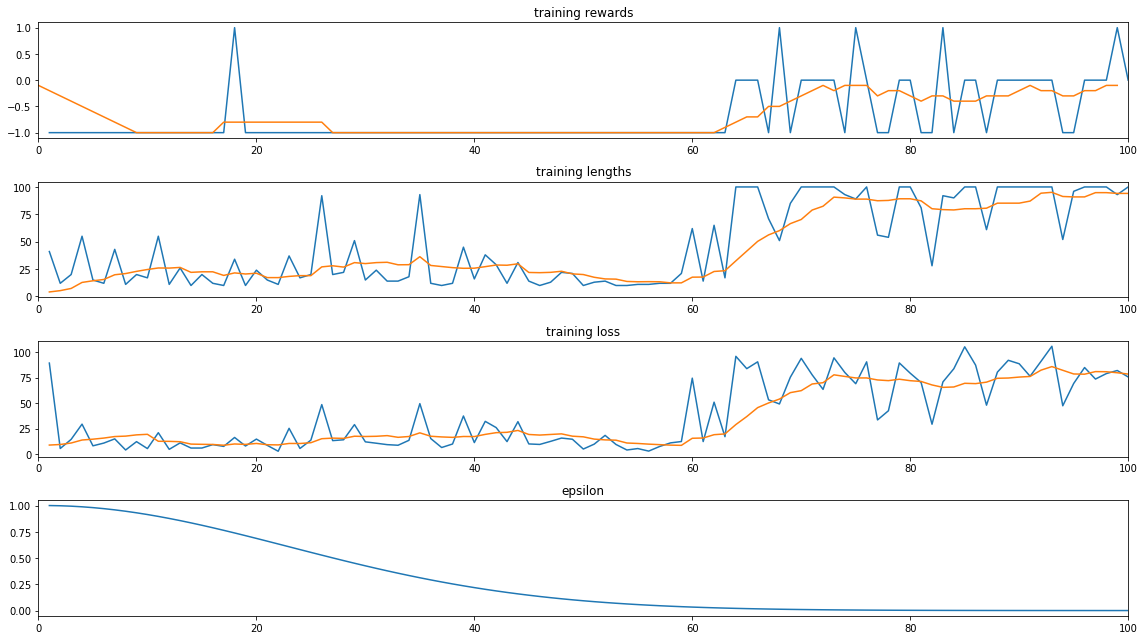

In [15]:
# plot results
def moving_average(a, n=10) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret / n

plt.figure(figsize=(16, 9))
plt.subplot(411)
plt.title('training rewards')
plt.plot(range(1, num_episodes+1), rewards)
plt.plot(moving_average(rewards))
plt.xlim([0, num_episodes])
plt.subplot(412)
plt.title('training lengths')
plt.plot(range(1, num_episodes+1), lengths)
plt.plot(range(1, num_episodes+1), moving_average(lengths))
plt.xlim([0, num_episodes])
plt.subplot(413)
plt.title('training loss')
plt.plot(range(1, num_episodes+1), losses)
plt.plot(range(1, num_episodes+1), moving_average(losses))
plt.xlim([0, num_episodes])
plt.subplot(414)
plt.title('epsilon')
plt.plot(range(1, num_episodes+1), epsilons)
plt.xlim([0, num_episodes])
plt.tight_layout(); plt.show()

In [20]:
## Save file
PATH = "resources/qAgent.pt"
torch.save(policy_dqn.state_dict(), PATH)

In [21]:
learning_rate = 0.001 # you know this by now
n_inputs = 372
n_hidden = 500
n_outputs = 6

class FirstAgent(BaseAgent):
    
    def __init__(self, character=characters.Bomber):
        super().__init__(character)
        self.policy_dqn = DQN(n_inputs, n_outputs, learning_rate)
        state_list = torch.load(PATH)
        self.policy_dqn.load_state_dict(state_list)
        
        
    def act(self, obs, action_space):
        # Kald neuralt netværk og return
        with torch.no_grad():
            a_prob = self.policy_dqn(np.atleast_1d(obs))
        a = (np.cumsum(a_prob.numpy()) > np.random.rand()).argmax() # sample action
        
        return a

In [22]:
# Add four random agents
agents = []
#for agent_id in range(4):
#    agents[agent_id] = RandomAgent(config["agent"](agent_id, config["game_type"]))
agents = {
    '0' : SimpleAgent(config["agent"](0, config["game_type"])),
    '1' : RandomAgent(config["agent"](1, config["game_type"])),
    '2' : RandomAgent(config["agent"](2, config["game_type"])),
    '3' : FirstAgent(config["agent"](3, config["game_type"]))
}
# Instantiate the environment
config = ffa_v0_fast_env()
env = Pomme(**config["env_kwargs"])
env.set_agents(list(agents.values()))
env.set_init_game_state(None)

In [25]:
# Seed and reset the environment
env.seed(0)
obs = env.reset()

# Run the random agents until we're done
done = False
while not done:
    env.render()
    actions = env.act(obs)
    obs, reward, done, info = env.step(actions)
env.render(close=True)
env.close()

print(info)
print (done)

{'result': <Result.Win: 0>, 'winners': [0]}
True


In [19]:
# creating DataFrame from targets_data
#targets_df = pd.DataFrame(data=targets_data)
#targets_df.columns = ['targets']

# creating tensor from targets_df 
#torch_tensor = torch.tensor(targets_df['targets'].values)

# printing out result
#print(torch_tensor
dataFrame = pd.DataFrame(data=s)
columns = dataFrame.columns 
torchTenssor = dataFrame[columns].values

#print(dataFrame.values.ravel('C'))
#print(dataFrame.stack())
#print (torch.tensor(.columns.values))
#print (obs[3]['board'])
#print (obs[3]['bomb_blast_strength'])
#print (obs[3])